<a href="https://colab.research.google.com/github/Anjalichimnani/CNN_Mask_Estimation/blob/master/CNN_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [2]:
! git clone https://github.com/Anjalichimnani/EVA4_Custom_Data.git

Cloning into 'EVA4_Custom_Data'...
remote: Enumerating objects: 373, done.
remote: Counting objects: 100% (373/373), done.
remote: Compressing objects: 100% (351/351), done.
remote: Total 373 (delta 32), reused 357 (delta 18), pack-reused 0
Receiving objects: 100% (373/373), 5.51 MiB | 39.21 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/EVA4/Assignment_15/15A/files/')
from imports.imports_eva import *

from supplements.Supplements import Supplements

from dataloaders.custom_data_loader import custom_data_loader
from models.CustomNet import CustomNet
from models.UNet import UNet
from models.Net import Net

In [5]:
import time
import glob
import torch
import os
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

from IPython.display import Image, clear_output 
print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.5.0+cu101 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [9]:
cd /content/EVA4_Custom_Data/

/content/EVA4_Custom_Data


In [0]:
!mkdir fg_images_flip
!mkdir mask_images_flip

!mkdir fg_bg_images
!mkdir mask_bg_images

!mkdir bg_images_all

In [15]:
root_path = '/content/EVA4_Custom_Data/'

!ls /content/EVA4_Custom_Data

addon_images	     code	     mask_bg_images    reference_images
Assignment15A.ipynb  fg_bg_images    mask_images
bg_images	     fg_images	     mask_images_flip
bg_images_all	     fg_images_flip  README.md


In [0]:
Supplements.flip_image_alpha ('/content/EVA4_Custom_Data/fg_images/', '/content/EVA4_Custom_Data/fg_images_flip/')

In [0]:
Supplements.flip_image_wo_alpha ('/content/EVA4_Custom_Data/mask_images/', '/content/EVA4_Custom_Data/mask_images_flip/')

In [0]:
Supplements.overlay_images (bgpath = '/content/EVA4_Custom_Data/bg_images/', fgpath = '/content/EVA4_Custom_Data/fg_images/', newpath = '/content/EVA4_Custom_Data/fg_bg_images/', name_prefix = 'base', bg_img_size = 224, fg_img_size = 112)

In [0]:
Supplements.overlay_images (bgpath = '/content/EVA4_Custom_Data/bg_images/', fgpath = '/content/EVA4_Custom_Data/fg_images_flip/', newpath = '/content/EVA4_Custom_Data/fg_bg_images/', name_prefix = 'flip', bg_img_size = 224, fg_img_size = 112)

In [20]:
!ls fg_bg_images | wc - l

 400000  400000 12800000 -
wc: l: No such file or directory
 400000  400000 12800000 total


In [0]:
Supplements.overlay_mask_images (bgpath = '/content/EVA4_Custom_Data/addon_images/', fgpath = '/content/EVA4_Custom_Data/mask_images/', newpath = '/content/EVA4_Custom_Data/mask_bg_images/', name_prefix = 'base', bg_img_size = 224, fg_img_size = 112)

In [0]:
Supplements.overlay_mask_images (bgpath = '/content/EVA4_Custom_Data/addon_images/', fgpath = '/content/EVA4_Custom_Data/mask_images_flip/', newpath = '/content/EVA4_Custom_Data/mask_bg_images/', name_prefix = 'flip', bg_img_size = 224, fg_img_size = 112)

In [0]:
Supplements.load_all_images (bgpath = '/content/EVA4_Custom_Data/bg_images/', fgpath = '/content/EVA4_Custom_Data/fg_images/', newpath = '/content/EVA4_Custom_Data/bg_images_all/', name_prefix = 'base', bg_img_size = 224, fg_img_size = 112)

In [0]:
Supplements.load_all_images (bgpath = '/content/EVA4_Custom_Data/bg_images/', fgpath = '/content/EVA4_Custom_Data/fg_images/', newpath = '/content/EVA4_Custom_Data/bg_images_all/', name_prefix = 'flip', bg_img_size = 224, fg_img_size = 112)

In [0]:
!ls bg_images_all | wc - l

 400000  400000 12800000 -
wc: l: No such file or directory
 400000  400000 12800000 total


In [0]:
classes = []


train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [0]:
from imports.imports_eva import *

class UNet (nn.Module):

    #Contracting Block
    def contractBlock (self, in_channels, out_channels, kernel_size = 3):
        block = nn.Sequential (
            nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, stride = 1, padding = 1, bias = False),
            nn.BatchNorm2d (num_features = out_channels),
            nn.ReLU(),

            nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = kernel_size, stride = 1, padding = 1, bias = False),
            nn.BatchNorm2d (num_features = out_channels),
            nn.ReLU()
        )
        return block

    def expandBlock (self, in_channels, mid_channels, out_channels, kernel_size = 3):
        block = nn.Sequential (
            nn.Conv2d (in_channels = in_channels, out_channels = mid_channels, kernel_size = kernel_size, stride = 1, padding = 0, bias = False),
            nn.BatchNorm2d (mid_channels),
            nn.ReLU(),

            nn.Conv2d (in_channels = mid_channels, out_channels = mid_channels, kernel_size = kernel_size, stride = 1, padding = 0, bias = False),
            nn.BatchNorm2d (mid_channels),
            nn.ReLU(),

            #Up Sampling
            nn.ConvTranspose2d (in_channels = mid_channels, out_channels = out_channels, kernel_size = 3, stride = 2, padding = 1, output_padding = 1, bias = False)
        )
        return block

    def finalBlock (self, in_channels, mid_channels, out_channels, kernel_size = 3, kernel_size_final = 1):
        block = nn.Sequential (
            nn.Conv2d (in_channels = in_channels, out_channels = mid_channels, kernel_size = kernel_size, stride = 1, padding = 0, bias = False),
            nn.BatchNorm2d (mid_channels),
            nn.ReLU(),

            nn.Conv2d (in_channels = mid_channels, out_channels = mid_channels, kernel_size = kernel_size, stride = 1, padding = 0, bias = False),
            nn.BatchNorm2d (mid_channels),
            nn.ReLU(),

            nn.Conv2d (in_channels = mid_channels, out_channels = out_channels, kernel_size = kernel_size, stride = 1, padding = 0, bias = False),
            nn.BatchNorm2d (out_channels),
            nn.ReLU()
        )
        return block

    def __init__ (self, in_channels, out_channels):
        super (UNet, self).__init__()

        #Encode
        self.convblock1 = self.contractBlock (in_channels = in_channels, out_channels = 64)
        self.pool1 = nn.MaxPool2d (kernel_size = 2, stride = 2)

        self.convblock2 = self.contractBlock (in_channels = 64, out_channels = 128)
        self.pool2 = nn.MaxPool2d (kernel_size = 2, stride = 2)

        self.convblock3 = self.contractBlock (in_channels = 128, out_channels = 256)
        self.pool3 = nn.MaxPool2d (kernel_size = 2, stride = 2)

        self.convblock4 = self.contractBlock (in_channels = 256, out_channels = 512)
        self.pool4 = nn.MaxPool2d (kernel_size = 2, stride = 2)

        #Base
        self.base = nn.Sequential (
            nn.Conv2d (in_channels = 512, out_channels = 1024, kernel_size = 3, stride = 1, padding = 0, bias = False),
            nn.BatchNorm2d (num_features= 1024),
            nn.ReLU(),

            nn.Conv2d (in_channels = 1024, out_channels = 1024, kernel_size = 3, stride = 1, padding = 0, bias = False),
            nn.BatchNorm2d (num_features = 1024),
            nn.ReLU(),

            nn.ConvTranspose2d (in_channels = 1024, out_channels = 512, kernel_size = 3, stride = 2, padding = 1, output_padding = 1, bias = False)
        )

        # Decode
        self.convblock5 = self.expandBlock (in_channels = 1024, mid_channels = 512, out_channels = 256)

        self.convblock6 = self.expandBlock (in_channels = 512, mid_channels = 256, out_channels = 128)

        self.convblock7 = self.expandBlock (in_channels = 256, mid_channels = 128, out_channels = 64)

        self.convblock_final = self.finalBlock (in_channels = 128, mid_channels = 64, out_channels = out_channels)

    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)

    def forward (self, x):

        # Encode
        conv_encode_1 = self.convblock1 (x)
        conv_encode_pool_1 = self.pool1 (conv_encode_1)

        conv_encode_2 = self.convblock2 (conv_encode_pool_1)
        conv_encode_pool_2 = self.pool2 (conv_encode_2)

        conv_encode_3 = self.convblock3 (conv_encode_pool_2)
        conv_encode_pool_3 = self.pool3 (conv_encode_3)

        conv_encode_4 = self.convblock4 (conv_encode_pool_3)
        conv_encode_pool_4 = self.pool4 (conv_encode_4)

        # Base
        conv_base = self.base (conv_encode_pool_4)

        # Decode
        concat_1 = self.crop_and_concat (conv_base, conv_encode_4, crop = True)
        conv_decode_1 = self.convblock5 (concat_1)

        concat_2 = self.crop_and_concat (conv_decode_1, conv_encode_3, crop = True)
        conv_decode_2 = self.convblock6 (concat_2)

        concat_3 = self.crop_and_concat (conv_decode_2, conv_encode_2, crop = True)
        conv_decode_3 = self.convblock7 (concat_3)

        concat_3 = self.crop_and_concat (conv_decode_3, conv_encode_1, crop = True)
        conv_final_layer = self.convblock_final (concat_3)

        return conv_final_layer


In [0]:
class CustomNet (nn.Module):

  def __init__ (self):
    super(CustomNet, self).__init__()

    self.conv_block_1 = nn.Sequential (
        nn.Conv2d (in_channels=6, out_channels=64, kernel_size= 3, bias = False),
        nn.BatchNorm2d (64),
        nn.ReLU()
    )

    self.conv_block_2 = nn.Sequential (
        nn.Conv2d (in_channels=64, out_channels=128, kernel_size=3),
        nn.BatchNorm2d (num_features=128),
        nn.ReLU()
    )

    self.pool1 = nn.MaxPool2d (kernel_size=2, stride=2)

    self.conv_block_3 = nn.Sequential (
        nn.Conv2d (in_channels=128, out_channels=128, kernel_size=3),
        nn.BatchNorm2d (num_features=128),
        nn.ReLU()
    )

    self.conv_block_4 = nn.Sequential (
        nn.Conv2d (in_channels=128, out_channels=256, kernel_size=3),
        nn.BatchNorm2d (num_features=256),
        nn.ReLU()
    )

    self.conv_block_5 = nn.Sequential (
        nn.Conv2d (in_channels=256, out_channels=1, kernel_size=3)
    )

  def forward (self, x):
    x = self.conv_block_1 (x)
    x = self.conv_block_2 (x)

    x = self.pool1 (x)

    x = self.conv_block_3 (x)
    x = self.conv_block_4 (x)
    x = self.conv_block_5 (x)

    return x

In [0]:
class Net(nn.Module):
    def __init__(self, drop=0):
        super(Net, self).__init__()
        self.drop = drop

        self.convblock1_1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.convblock1_2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, stride=1, padding=1, bias=False, groups=32),
            nn.Conv2d(32, 64, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.convblock2_1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.convblock2_2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, stride=1, padding=1, bias=False, groups=32),
            nn.Conv2d(32, 64, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.convblock3 = nn.Sequential(
            nn.Conv2d(128, 64, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.convblock4 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.convblock5 = nn.Sequential(
            nn.Conv2d(128, 256, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.convblock6 = nn.Sequential(
            nn.Conv2d(256, 1, 3, stride=1, padding=1, bias=False),
        )

    def forward(self, input1, input2):
        x1 = input1
        x2 = input2

        x1 = self.convblock1_2(self.convblock1_1(x1))
        x2 = self.convblock2_2(self.convblock2_1(x2))

        x_1 = torch.cat([x1, x2], dim=1)

        x = self.convblock3(x_1)
        x = self.convblock4(x)

        x = (x + x_1)

        x = self.convblock5(x)
        x = self.convblock6(x)

        return x

In [0]:
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print (device)

model = UNet(in_channels=6, out_channels=1).to(device)
summary (model, input_size=(6, 224, 224))
#print (model)

In [0]:
data_transform = custom_data_loader.get_def_data_transform()

In [0]:
dataset = custom_data_loader.custom_data_set(root_path = '/content/EVA4_Custom_Data/', folder = 'images', transform = data_transform)
dataset = custom_data_loader.custom_data_set(root_path = '/content/EVA4_Custom_Data/', folder = 'images', transform = data_transform)


In [19]:
dataset_loader = custom_data_loader.custom_data_loader (dataset, batch_size=128, num_workers=4, shuffle=True)
test_dataset_loader = custom_data_loader.custom_data_loader (dataset_test, batch_size=128, num_workers=4, shuffle=False)

ValueError: ignored

In [0]:
PATH = '/content/gdrive/My Drive/EVA4/Assignment_15/15A/files/Model_UNet_14_06.pth'

In [0]:
#criterion = nn.L1Loss().cuda()
#criterion = nn.MSELoss().cuda()
#criterion = nn.CrossEntropyLoss().cuda()
criterion = nn.BCEWithLogitsLoss().cuda()

In [0]:
def train(model, device, train_loader, optimizer, epoch, criterion):
  train_losses = []
  train_acc = []
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0

  for batch_idx, (data) in enumerate(pbar):
    idx = 0
    # get samples
    images = data["Image"].to(device) 
    image_bgs = data["Image_Bg"].to(device) 
    masks = data["Mask"].to(device)

    image_and_bg = torch.cat ((images,image_bgs), dim = 1)

    # Init
    optimizer.zero_grad()

    # Predict
    y_pred = model(image_and_bg)

    # Calculate loss
    criterion = criterion
    loss = criterion(y_pred, masks)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    if batch_idx % 1500 == 0:
      torch.save(model.state_dict(), PATH)

    pbar.set_description(desc= f'Loss={loss.item():0.3f} Batch_id={batch_idx} ')
    train_acc.append(loss)

  return train_losses, train_acc

def test(model, device, test_loader):
  model.eval()
  test_losses = []
  test_acc = []
  test_loss = 0
  correct = 0

  with torch.no_grad():
      for idx, data in enumerate(test_loader):
        images = data["Image"].to(device) 
        image_bgs = data["Image_Bg"].to(device)   
        masks = data["Mask"].to(device)

        image_and_bg = torch.cat ((images,image_bgs), dim = 1)

        output = model(image_and_bg)
        criterion = nn.BCEWithLogitsLoss().cuda()
        test_loss += criterion(output, masks).item()  # sum up batch loss


  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)

  print('\nTest set: Average loss: {:.4f}, Accuracy: /{} \n'.format(
      test_loss, len(test_loader.dataset)))
  
  test_acc.append(test_loss)
  return test_losses, test_acc

In [0]:
model = UNet(in_channels=6, out_channels=1).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.000001)  # Removed Weight Decay
scheduler = StepLR(optimizer, step_size=1, gamma=0.01)

In [0]:
from tqdm.notebook import tqdm

EPOCHS = 5
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    a,b = train(model, device, dataset_loader, optimizer, epoch)
    train_losses.extend(a)
    train_acc.extend(b)

    scheduler.step()
    print('')

In [0]:
images = iter(dataset_loader).next()

print (images["Mask"][0].shape)
image = images["Image"].to(device)
image_bg = images["Image_Bg"].to(device)
masks = images["Mask"].to(device)
#print (images["Image"][0])

image_and_bg = torch.cat ((image, image_bg), dim = 1)

y_pred = model(image_and_bg)

print (y_pred[0][0].shape)

torch.Size([1, 24, 24])
torch.Size([24, 24])


torch.Size([1, 64, 64])


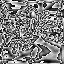

In [0]:
pilimage_transform = transforms.ToPILImage ()

print (y_pred[0].shape)
img_check = pilimage_transform (y_pred[0].cpu())

display (img_check)

In [0]:
def show_image(inp, n_row=8, title=None, mean=None, std=None):
    """Imshow for Tensor."""
    inp = torchvision.utils.make_grid(inp.detach().cpu(), n_row)
    inp = inp.numpy().transpose((1, 2, 0))
    if mean:
        mean = np.array(mean)
        std = np.array(std)
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(10, 10))
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updateddef show_image(inp, n_row=8, title=None, mean=None, std=None):
    """Imshow for Tensor."""
    inp = torchvision.utils.make_grid(inp.detach().cpu(), n_row)
    inp = inp.numpy().transpose((1, 2, 0))
    if mean:
        mean = np.array(mean)
        std = np.array(std)
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(10, 10))
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


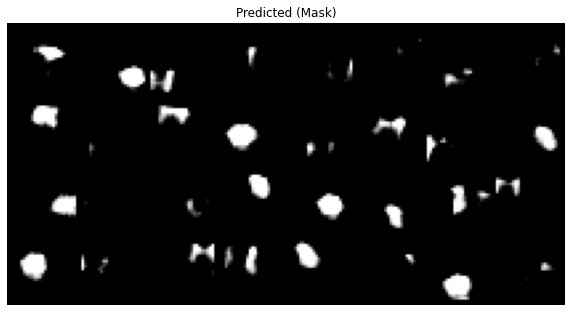

AttributeError: ignored

In [0]:
show_image(y_pred[::4], n_row=8, title='Predicted (Mask)')


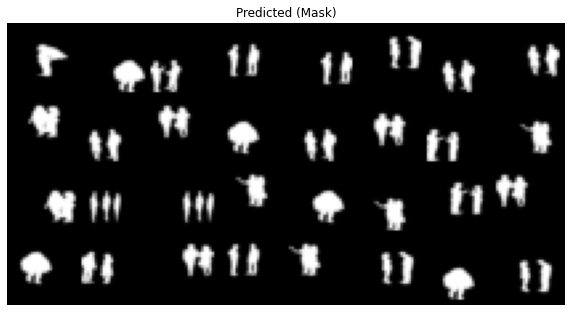

AttributeError: ignored

In [0]:
show_image(masks[::4].cpu(), n_row=8, title='Predicted (Mask)')

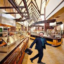

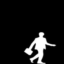

In [0]:
#print (type(images["Image"][0]))
pilimage_transform = transforms.ToPILImage ()
image = pilimage_transform (images["Image"][0])

display (image)
mask = pilimage_transform (images["Mask"][0])
display (mask)

In [0]:
'''
#!mkdir fg_bg_subset
#!mkdir mask_bg_subset
'''

In [0]:
'''
#img_all = list(sorted(os.listdir(os.path.join(root_path, "fg_bg_images"))))
#mask_all = list(sorted(os.listdir(os.path.join(root_path, "mask_bg_images"))))
'''

In [0]:
'''
#for img in img_all[:100]:
#  url = root_path + 'fg_bg_images/' + img
#  !gsutil cp {url} /content/EVA4_Custom_Data/fg_bg_subset
'''

In [0]:
'''
#for mask in mask_all[:100]:
#  url = root_path + 'mask_bg_images/' + mask
#  !gsutil cp {url} /content/EVA4_Custom_Data/mask_bg_subset
'''

In [0]:
'''
from PIL import Image
import tensorflow as tf


img = Image.open('/content/EVA4_Custom_Data/fg_bg_subset/base_fg_img001_bg_img001_01.jpg')
img_bg = Image.open('/content/EVA4_Custom_Data/bg_images/img001.jpg')
mask = Image.open('/content/EVA4_Custom_Data/mask_bg_subset/base_mask_img001_bg_black_image_001_01.jpg')

display(mask)

mask = np.array(mask)
transforn_to_tensor = transforms.ToTensor ()
img = transforn_to_tensor(img)
img_bg = transforn_to_tensor(img_bg)

obj_ids = np.unique(mask)
obj_ids = obj_ids[1:]
masks = transforms.ToTensor()

img_check = transforms.ToPILImage()


'''

"\nfrom PIL import Image\nimport tensorflow as tf\n\n\nimg = Image.open('/content/EVA4_Custom_Data/fg_bg_subset/base_fg_img001_bg_img001_01.jpg')\nimg_bg = Image.open('/content/EVA4_Custom_Data/bg_images/img001.jpg')\nmask = Image.open('/content/EVA4_Custom_Data/mask_bg_subset/base_mask_img001_bg_black_image_001_01.jpg')\n\ndisplay(mask)\n\nmask = np.array(mask)\ntransforn_to_tensor = transforms.ToTensor ()\nimg = transforn_to_tensor(img)\nimg_bg = transforn_to_tensor(img_bg)\n\nobj_ids = np.unique(mask)\nobj_ids = obj_ids[1:]\nmasks = transforms.ToTensor()\n\nimg_check = transforms.ToPILImage()\n\n\n"

In [0]:
cd /content

/content


In [0]:
images = iter(dataset_loader).next()
print (images["Mask"][0].shape)
print (images["Image"][0])
# images.shape = ( 32, 3, 80, 80)
numpy_images = images["Image"].numpy()

pop_channel_std = np.std(numpy_images, axis=(0, 2, 3))
pop_channel_mean = np.mean(numpy_images, axis=(0, 2, 3))

print (pop_channel_mean)
print (pop_channel_std)

torch.Size([1, 24, 24])
tensor([[[0.0078, 0.0078, 0.0078,  ..., 0.1804, 0.1804, 0.1804],
         [0.0118, 0.0118, 0.0078,  ..., 0.1882, 0.1882, 0.1882],
         [0.0235, 0.0235, 0.0196,  ..., 0.1922, 0.1922, 0.1922],
         ...,
         [0.6353, 0.6353, 0.6353,  ..., 0.3451, 0.2000, 0.0471],
         [0.5882, 0.5647, 0.5569,  ..., 0.1922, 0.1098, 0.0549],
         [0.4275, 0.4471, 0.4353,  ..., 0.3020, 0.3843, 0.3529]],

        [[0.4824, 0.4824, 0.4824,  ..., 0.4902, 0.4902, 0.4902],
         [0.4902, 0.4902, 0.4863,  ..., 0.4980, 0.4980, 0.4980],
         [0.4941, 0.4941, 0.4941,  ..., 0.5020, 0.5020, 0.5020],
         ...,
         [0.6000, 0.6000, 0.5961,  ..., 0.1725, 0.1490, 0.1020],
         [0.5647, 0.5451, 0.5451,  ..., 0.1294, 0.0784, 0.0902],
         [0.4118, 0.4392, 0.4353,  ..., 0.2706, 0.3098, 0.2745]],

        [[0.7922, 0.7922, 0.7922,  ..., 0.8000, 0.8000, 0.8000],
         [0.7961, 0.7961, 0.7922,  ..., 0.8078, 0.8078, 0.8078],
         [0.7961, 0.7961, 0.7922, 

In [0]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 8480, done.
remote: Total 8480 (delta 0), reused 0 (delta 0), pack-reused 8480
Receiving objects: 100% (8480/8480), 10.30 MiB | 4.51 MiB/s, done.
Resolving deltas: 100% (5846/5846), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


In [0]:
class OfficeDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "fg_bg_subset"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "mask_bg_subset"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "fg_bg_subset", self.imgs[idx])
        mask_path = os.path.join(self.root, "mask_bg_subset", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        target = mask
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [0]:
from torchvision.transforms import functional as transform_f

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


class RandomHorizontalFlip(object):
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            
            height_mask, width_mask = target.shape[-2:]
            target = target.flip(-1)

        return image, target


class ToTensor(object):
    def __call__(self, image, target):
        image = transform_f.to_tensor(image)
        target = transform_f.to_tensor(target)
        return image, target


In [0]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [0]:
dataset = OfficeDataset(root = '/content/EVA4_Custom_Data/', transforms = None)
dataset[3]
print (len (dataset))

100


In [0]:
data_transform = transforms.Compose([
        #transforms.RandomCrop (16),
        transforms.RandomRotation(5),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4770698,  0.44741154, 0.3993873 ],
                           std=[0.27973273, 0.27094352, 0.28073433])
    ])


In [0]:
dataset = OfficeDataset(root = '/content/EVA4_Custom_Data/', transforms = data_transform)
dataset_test = OfficeDataset(root = '/content/EVA4_Custom_Data/', transforms = data_transform)

dataset[0]

TypeError: ignored

In [0]:
dataset_loader = torch.utils.data.DataLoader (dataset, batch_size=12, shuffle=True, num_workers=4)
test_dataset_loader = torch.utils.data.DataLoader (dataset_test, batch_size=12, shuffle=False, num_workers=4)

NameError: ignored

In [0]:
images, targets = iter(dataset_loader).next()
#print (images[0])
print (targets[0])
# images.shape = ( 32, 3, 80, 80)
numpy_images = images.numpy()



pop_channel_std = np.std(numpy_images, axis=(0, 2, 3))
pop_channel_mean = np.mean(numpy_images, axis=(0, 2, 3))

print (pop_channel_mean)
print (pop_channel_std)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
[0.598836   0.64986354 0.6657431 ]
[0.26040068 0.2488874  0.26616424]


In [0]:
train_data = []
train_labels = []


print (len(train_data))
print (train_labels[0])

100000
n02124075


In [0]:
val_data = []
val_labels = []

url = root_path + 'val'

file = open(url + "/val_annotations.txt", "r")

for line in file:
  line_desc = line.strip().split("\t")
  val_data.append (plt.imread(url+"/images/{}".format(line_desc[0]), 'RGB'))
  val_labels.append (line_desc[1])

file.close()

print (len(val_data))
print (val_labels[0])

10000
n03444034


In [0]:
data_transform = transforms.Compose([
        #transforms.RandomCrop (16),
        transforms.RandomRotation(5),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4770698,  0.44741154, 0.3993873 ],
                           std=[0.27973273, 0.27094352, 0.28073433])
    ])

#test_data_transform = transforms.Compose([
        #transforms.ToPILImage(),
#        transforms.ToTensor(),
#        transforms.Normalize(mean=[0.4770698,  0.44741154, 0.3993873 ],
#                           std=[0.27973273, 0.27094352, 0.28073433])
#    ])

train_data_subset = datasets.ImageFolder(root=root_path + 'fg_bg_subset/',
                                           transform=data_transform)


#dataset_loader = torch.utils.data.DataLoader(tinyimagenet_train_dataset,
#                                             batch_size=512, shuffle=True,
#                                             num_workers=4)

#tinyimagenet_test_dataset = datasets.ImageFolder (root = root_path + 'val', transform = test_data_transform)
#test_dataset_loader = torch.utils.data.DataLoader (tinyimagenet_test_dataset, batch_size=512, shuffle=False, num_workers=4)

RuntimeError: ignored

In [0]:
"""
validation_split = 0.3
random_seed = 1

dataset_size = len(tinyimagenet_train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

print (dataset_size)
print (split)

np.random.seed(random_seed)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

print (len(val_indices))

dataset_loader = torch.utils.data.DataLoader(tinyimagenet_train_dataset, batch_size=512, 
                                           sampler=train_sampler)
test_dataset_loader = torch.utils.data.DataLoader(tinyimagenet_train_dataset, batch_size=512,
                                                sampler=valid_sampler)

print (len(dataset_loader))
"""

'\nvalidation_split = 0.3\nrandom_seed = 1\n\ndataset_size = len(tinyimagenet_train_dataset)\nindices = list(range(dataset_size))\nsplit = int(np.floor(validation_split * dataset_size))\n\nprint (dataset_size)\nprint (split)\n\nnp.random.seed(random_seed)\nnp.random.shuffle(indices)\ntrain_indices, val_indices = indices[split:], indices[:split]\n\n# Creating PT data samplers and loaders:\ntrain_sampler = SubsetRandomSampler(train_indices)\nvalid_sampler = SubsetRandomSampler(val_indices)\n\nprint (len(val_indices))\n\ndataset_loader = torch.utils.data.DataLoader(tinyimagenet_train_dataset, batch_size=512, \n                                           sampler=train_sampler)\ntest_dataset_loader = torch.utils.data.DataLoader(tinyimagenet_train_dataset, batch_size=512,\n                                                sampler=valid_sampler)\n\nprint (len(dataset_loader))\n'

In [0]:
train_set, val_set = torch.utils.data.random_split(tinyimagenet_train_dataset, [int(0.7*(len(tinyimagenet_train_dataset))), int(0.3*(len(tinyimagenet_train_dataset)))])

dataset_loader = torch.utils.data.DataLoader (train_set, batch_size=512, shuffle=True, num_workers=4)
test_dataset_loader = torch.utils.data.DataLoader (val_set, batch_size=512, shuffle=False, num_workers=4)

TypeError: ignored

In [0]:
print (len(tinyimagenet_train_dataset))
print (tinyimagenet_train_dataset.samples[99999])
print (tinyimagenet_train_dataset.class_to_idx)

100000
('IMagenet/tiny-imagenet-200/train/n12267677/images/n12267677_99.JPEG', 199)
{'n01443537': 0, 'n01629819': 1, 'n01641577': 2, 'n01644900': 3, 'n01698640': 4, 'n01742172': 5, 'n01768244': 6, 'n01770393': 7, 'n01774384': 8, 'n01774750': 9, 'n01784675': 10, 'n01855672': 11, 'n01882714': 12, 'n01910747': 13, 'n01917289': 14, 'n01944390': 15, 'n01945685': 16, 'n01950731': 17, 'n01983481': 18, 'n01984695': 19, 'n02002724': 20, 'n02056570': 21, 'n02058221': 22, 'n02074367': 23, 'n02085620': 24, 'n02094433': 25, 'n02099601': 26, 'n02099712': 27, 'n02106662': 28, 'n02113799': 29, 'n02123045': 30, 'n02123394': 31, 'n02124075': 32, 'n02125311': 33, 'n02129165': 34, 'n02132136': 35, 'n02165456': 36, 'n02190166': 37, 'n02206856': 38, 'n02226429': 39, 'n02231487': 40, 'n02233338': 41, 'n02236044': 42, 'n02268443': 43, 'n02279972': 44, 'n02281406': 45, 'n02321529': 46, 'n02364673': 47, 'n02395406': 48, 'n02403003': 49, 'n02410509': 50, 'n02415577': 51, 'n02423022': 52, 'n02437312': 53, 'n02480

In [0]:
images, labels = iter(dataset_loader).next()
print (images[0])
# images.shape = ( 32, 3, 80, 80)
numpy_images = images.numpy()



pop_channel_std = np.std(numpy_images, axis=(0, 2, 3))
pop_channel_mean = np.mean(numpy_images, axis=(0, 2, 3))

print (pop_channel_mean)
print (pop_channel_std)

tensor([[[-1.7054,  0.6497,  0.3834,  ..., -1.7054, -1.7054, -1.7054],
         [-1.7054,  0.2712,  0.4535,  ...,  0.6638,  0.5937,  0.6357],
         [-1.7054,  0.3834,  0.6778,  ...,  0.5796,  0.6077,  0.6497],
         ...,
         [ 0.4815,  0.5656,  0.4395,  ...,  0.7058,  0.8320, -1.7054],
         [ 0.3834,  0.5796,  0.4675,  ...,  0.5376,  0.6497, -1.7054],
         [-1.7054, -1.7054, -1.7054,  ...,  0.4114,  0.5236, -1.7054]],

        [[-1.6513,  0.8092,  0.5342,  ..., -1.6513, -1.6513, -1.6513],
         [-1.6513,  0.4184,  0.6066,  ...,  0.7948,  0.7224,  0.7658],
         [-1.6513,  0.5342,  0.8382,  ...,  0.7079,  0.7369,  0.7803],
         ...,
         [ 0.6645,  0.7513,  0.6211,  ...,  0.8961,  1.0263, -1.6513],
         [ 0.5632,  0.7658,  0.6500,  ...,  0.7224,  0.8382, -1.6513],
         [-1.6513, -1.6513, -1.6513,  ...,  0.5921,  0.7079, -1.6513]],

        [[-1.4227,  0.9102,  0.6448,  ..., -1.4227, -1.4227, -1.4227],
         [-1.4227,  0.5330,  0.7146,  ...,  0

In [0]:
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print (device)

model = ResNet18().to(device)
summary (model, input_size=(3, 224, 224))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,728
       BatchNorm2d-2         [-1, 64, 224, 224]             128
            Conv2d-3         [-1, 64, 224, 224]          36,864
       BatchNorm2d-4         [-1, 64, 224, 224]             128
            Conv2d-5         [-1, 64, 224, 224]          36,864
       BatchNorm2d-6         [-1, 64, 224, 224]             128
        BasicBlock-7         [-1, 64, 224, 224]               0
            Conv2d-8         [-1, 64, 224, 224]          36,864
       BatchNorm2d-9         [-1, 64, 224, 224]             128
           Conv2d-10         [-1, 64, 224, 224]          36,864
      BatchNorm2d-11         [-1, 64, 224, 224]             128
       BasicBlock-12         [-1, 64, 224, 224]               0
           Conv2d-13        [-1, 128, 112, 112]          73,728
      BatchNorm2d-14        [-1, 1

In [0]:
def train(model, device, train_loader, optimizer, epoch):
  train_losses = []
  train_acc = []
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data) in enumerate(pbar):
    # get samples
    data = data.to(device)

    # Init
    optimizer.zero_grad()

    # Predict
    y_pred = model(data)

    # Calculate loss
    criterion = nn.L1Loss().cuda()
    loss = criterion(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item():0.3f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
  return train_losses, train_acc

def test(model, device, test_loader):
  model.eval()
  test_losses = []
  test_acc = []
  test_loss = 0
  correct = 0
  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          criterion = nn.L1Loss().cuda()
          test_loss += criterion(output, target).item()  # sum up batch loss
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))
  
  test_acc.append(100. * correct / len(test_loader.dataset))
  return test_losses, test_acc

In [0]:
model = UNet(in_channels = 3, out_channels = 2).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.001)  # Removed Weight Decay
scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

In [0]:
EPOCHS = 1
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    a,b = train(model, device, dataset_loader, optimizer, epoch)
    train_losses.extend(a)
    train_acc.extend(b)
    c,d = test(model, device, test_dataset_loader)
    test_losses.extend(c)
    test_acc.extend(d)
    scheduler.step()
    print('')


  0%|          | 0/9 [00:00<?, ?it/s]

EPOCH: 1


ValueError: ignored

In [0]:
class TinyImageNetDataSet (Dataset):
  ### Tiny Image Net Data set Class ###

  def __init__(self, class_file, root_dir, transform=None):
    classes = []
    train_data = []
    train_labels = []

    file = open(class_file, "r")

    for line in file:
      self.classes.append(line.strip())

    file.close()

    url = root_dir + 'train'

    for class_name in self.classes:
      for i in range (500):
        self.train_data.append(plt.imread( (url + "/{}/images/{}_{}.JPEG".format(class_name, class_name, str(i))), 'RGB'))
        self.train_labels.append(class_name)

    print (len(self.train_data))
    print (self.train_labels[0])

  def __len__(self):
    return len(self.train_data)

  def __getitem__(self, idx):
    


SyntaxError: ignored

In [0]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=128,
                                              shuffle=True, num_workers=4)

In [0]:
testloader = torch.utils.data.DataLoader(val_data, batch_size=128,
                                             shuffle=False, num_workers=4)

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = gm.get_model_instance().to(device)
summary(model, input_size=(3, 64, 64))

In [0]:
model = gm.get_model_instance().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.001)
scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

In [0]:
EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    a,b = ttd.train(model, device, trainloader, optimizer, epoch)
    train_losses.extend(a)
    train_acc.extend(b)
    c,d = ttd.test(model, device, testloader)
    test_losses.extend(c)
    test_acc.extend(d)
    scheduler.step()
    print('')